# Using Facial Emotions Classification to Boost Retail Sales

This project explores the potential of using facial emotion recognition to boost sales within retail stores. Outside of online and print advertisements, retail stores have displays that draws in potential customers. This project attempts to draw in potential customers into retail stores by determining their facial emotion and using that to quickly decide on whether to change the displays available. While an facial emotion displaying one of disgust and fear may stop someone from entering the retail store, an emotion displaying happiness, or surprise may draw them in.

## Table of Contents

[Initializations](#Initializations)

[Dataset](#Dataset)

[Modeling](#Modeling)

[Identifying Issues with Emotions](#Identifying-Issues-with-Emotions)

## Initializations

In this section are a couple of variables that will be initialized and used throughout the project

In [1]:
# model related initializations
load_model = False
model_path = ''
model_name = 'facial_expression_normalization_model.h5'
model_name2 = 'facial_expression_normalization_model2.h5'
model_name3 = 'three_facial_emotion_model.h5'
model_name4 = 'anger_disgust_happy_neutral_model.h5'
batch_size = 64
epochs = 20

# dataset related initialization
# out of the 7 emotions available in the dataset, only 5 will be utilized: angry, disgust, happy, surprise, neutral
num_classes = 5
emotion_values = ['angry', 'disgust', 'happy', 'surprise', 'neutral']
width, height, color = 48, 48, 1
input_shape = (width, height, color)

## Dataset

The dataset used to train facial emotions comes from a previous [2013 kaggle competition](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge). This dataset contains over 28,000 training data and over 7,000 test data used to validate and test the model. Each image contained within the dataset is a 48x48 pixel grayscale image of a face. The images are relatively centered and occupies about the same amount of space in each image.

In [2]:
with open("fer2013.csv") as f:
    content = f.readlines()

In [3]:
# see sample content of csv file
print(content[0])
print(content[1])

emotion,pixels,Usage

0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 2

As we observe from the output of the first two lines of the dataset file, we notice that it contains three features: emotion, pixels, and Usage. Emotion is a labeling feature that categorizes the facial expression to one of seven categories (0 = Angry, 1 = Disgust, 2 = Fear, 3 = Happy, 4 = Sad, 5 = Surprise, 6 = Neutral). For this project's intents and purposes, we will be primarily be looking at five emotions, anger, disgust, happy, surprise, and neutral. The emotions fear and sadness do not apply to this type of advertisement.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
%matplotlib inline

Using TensorFlow backend.


In [5]:
faces = np.array(content)
print("There are a total of {} pictures".format(len(faces)))

There are a total of 35888 pictures


In [6]:
def set_train_test_data(faces):
    
    # initialize training and test set
    x_train, y_train, x_test, y_test = [], [], [], []

    for i, instance in enumerate(faces):

        # skip first step; header
        if i == 0:
            continue

        emotion, pixel, usage = instance.split(',')

        img = np.array(pixel.split(" "))

        if emotion in ['0', '1', '3', '5', '6']:

            if emotion == '3':
                emotion = '2'
            elif emotion == '5':
                emotion = '3'
            elif emotion == '6':
                emotion = '4'

            if 'Training' in usage:
                x_train.append(img)
                y_train.append(emotion)
            else:
                x_test.append(img)
                y_test.append(emotion)

    print("There are {} training data and {} test cases".format(len(y_train), len(y_test)))
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = set_train_test_data(faces)

There are 19782 training data and 4907 test cases


After removing two of the facial emotions, the training data drops from over 28,000 to around 19,000 and the training data drops from over 7,000 to around 4,900

## Modeling

Now that the data is loaded, it is now time to generate a model that will be able to classify the emotions. First, a baseline accuracy rate will be determined using Principal Component Analysis (PCA) and a Random Forest model. Once I find a baseline accuracy rate, I'll then use a convolutional neural network (CNN) using Keras and Tensorflow will be used to improve upon it.

## Setting the Baseline

In [7]:
import pandas as pd

feat_cols = [ 'pixel '+str(i+1) for i in range(width*height*color)]
df = pd.DataFrame(x_train+x_test, columns=feat_cols)
df['label'] = y_train+y_test

In [8]:
df.head()

,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,pixel 9,pixel 10,...,pixel 2296,pixel 2297,pixel 2298,pixel 2299,pixel 2300,pixel 2301,pixel 2302,pixel 2303,pixel 2304,label
0,70,80,82,72,58,58,60,63,54,58,...,182,183,136,106,116,95,106,109,82,0
1,151,150,147,155,148,133,111,140,170,174,...,108,95,108,102,67,171,193,183,184,0
2,4,0,0,0,0,0,0,0,0,0,...,34,31,31,31,27,31,30,29,30,4
3,77,78,79,79,78,75,60,55,47,48,...,124,139,150,179,180,175,125,67,68,2
4,85,84,90,121,101,102,133,153,153,169,...,151,111,106,102,99,89,58,73,84,2


In [9]:
# get position of label for use later
label_pos = len(df.columns)-1

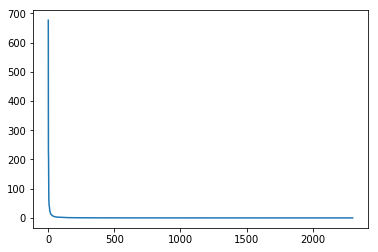

In [10]:
# find how many pca components to use
from sklearn.preprocessing import StandardScaler

df_pca = df[feat_cols]

# normalize data
X = StandardScaler().fit_transform(df_pca)

# transpose matrix
Cx = np.cov(X.T)

# get eigenvalues and vectors
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

plt.plot(eig_val_cov)
plt.show()

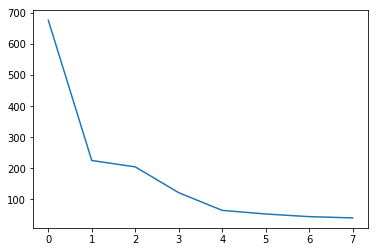

In [11]:
# not very informative. limit number of eigen values

plt.plot(eig_val_cov[:8])
plt.show()

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
df['pca-four'] = pca_result[:,3]

print(pca.explained_variance_ratio_)

[0.29064697 0.10268338 0.09279428 0.05513855]


In [13]:
# show the dataframe with the pca values
df.head()

,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,pixel 9,pixel 10,...,pixel 2300,pixel 2301,pixel 2302,pixel 2303,pixel 2304,label,pca-one,pca-two,pca-three,pca-four
0,70,80,82,72,58,58,60,63,54,58,...,116,95,106,109,82,0,728.167470,-624.352538,675.851696,-413.355401
1,151,150,147,155,148,133,111,140,170,174,...,67,171,193,183,184,0,-44.269447,755.789118,-382.175523,-496.038178
2,4,0,0,0,0,0,0,0,0,0,...,27,31,30,29,30,4,1844.072825,-1748.535298,-911.142174,-3.464172
3,77,78,79,79,78,75,60,55,47,48,...,180,175,125,67,68,2,1065.058390,-1211.813421,166.291979,604.470258
4,85,84,90,121,101,102,133,153,153,169,...,99,89,58,73,84,2,-1564.419220,-2234.973432,425.538869,-156.844421


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier()
average_score = cross_val_score(rf, df.iloc[:, label_pos+1:], df.iloc[:, label_pos], cv=10)

In [15]:
print('Baseline performance of the Random Forest model with PCA values is {0:.2f}% with a standard deviation of +/- {1:.2f}'.format(average_score.mean()*100, average_score.std()*2))

Baseline performance of the Random Forest model with PCA values is 41.84% with a standard deviation of +/- 0.02


Now that the baseline accuracy has been achieved, the CNN model will be run with the intent of performing better than the Random Forest model accuracy rating.

In [16]:
from keras.preprocessing.image import array_to_img, image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, AveragePooling2D, BatchNormalization, Flatten, Dense
from keras import backend as K

In [17]:
# allocates GPU memory based on runtime allocations. doesn't releases memory because of potential memory fragmentation
# without this option, getting images will not work
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

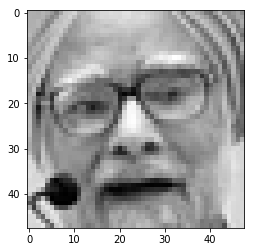

In [18]:
# sample picture
sample = np.array(faces[2].split(",")[1].split(" "))
sample = sample.reshape(width, height, 1)
plt.imshow(array_to_img(sample))
plt.show()

In [19]:
def convertLabelsToCategoryLabels(label):
    # convert the labels into categories
    tmp = []
    for emotion in label:
        emotion = keras.utils.to_categorical(emotion, num_classes)
        tmp.append(emotion)
    return tmp

y_train = convertLabelsToCategoryLabels(y_train)
y_test = convertLabelsToCategoryLabels(y_test)

In [20]:
def convertListToArray(x_train, y_train, x_test, y_test, width, height):
    # need to convert list into arrays to work with CNNs
    x_train = np.array(x_train, 'float32')
    y_train = np.array(y_train, 'float32')
    x_test = np.array(x_test, 'float32')
    y_test = np.array(y_test, 'float32')

    # normalize values between 0 - 1
    x_train = x_train / 255.0
    x_test = x_test / 255.0

    # reshape values into image format
    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, width, height)
        x_test = x_test.reshape(x_test.shape[0], 1, width, height)
        input_shape = (1, width, height)
    else:
        x_train = x_train.reshape(x_train.shape[0], width, height, 1)
        x_test = x_test.reshape(x_test.shape[0], width, height, 1)
        input_shape = (width, height, 1)
    
    return x_train, y_train, x_test, y_test, input_shape

In [21]:
x_train, y_train, x_test, y_test, input_shape = convertListToArray(x_train, y_train, x_test, y_test, width, height)

In [22]:
# create CNN model
model = Sequential()

# first CNN layer
model.add(Conv2D(49, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

# second CNN layer
model.add(Conv2D(49, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))

# third CNN layer
model.add(Conv2D(98, (3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

# flatten to use for dense layers
model.add(Flatten())
model.add(Dense(784, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [23]:
def load_or_save_model(model, path_and_file_name, load_model=False):
    if (load_model):
        model.load_weights(path_and_file_name)
    else:
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_test, y_test))
        score = model.evaluate(x_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        model.save_weights(path_and_file_name)
    
    return model

model = load_or_save_model(model, model_path+model_name, load_model)

Train on 19782 samples, validate on 4907 samples
Epoch 1/20
19782/19782 [==============================] - 9s 476us/step - loss: 1.2325 - acc: 0.4861 - val_loss: 1.0876 - val_acc: 0.5441
Epoch 2/20
19782/19782 [==============================] - 7s 360us/step - loss: 0.9776 - acc: 0.6103 - val_loss: 0.8540 - val_acc: 0.6603
Epoch 3/20
19782/19782 [==============================] - 7s 359us/step - loss: 0.8836 - acc: 0.6557 - val_loss: 0.8261 - val_acc: 0.6705
Epoch 4/20
19782/19782 [==============================] - 7s 360us/step - loss: 0.8349 - acc: 0.6758 - val_loss: 0.7930 - val_acc: 0.6800
Epoch 5/20
19782/19782 [==============================] - 7s 359us/step - loss: 0.7945 - acc: 0.6896 - val_loss: 0.7195 - val_acc: 0.7204
Epoch 6/20
19782/19782 [==============================] - 7s 359us/step - loss: 0.7608 - acc: 0.7086 - val_loss: 0.7039 - val_acc: 0.7279
Epoch 7/20
19782/19782 [==============================] - 7s 359us/step - loss: 0.7302 - acc: 0.7161 - val_loss: 0.6792 - v

In [24]:
# set up dictionary to generate crosstab
dic = {key:value for key, value in zip(list(set(y_test.argmax(axis=-1))), emotion_values)}

predictions = model.predict(x_test)

def show_confusion_matrix(predictions, emotion_values):
    # convert id values into string values
    prediction_string = []
    actual_string = []
    
    for value in predictions.argmax(axis=-1):
        prediction_string.append(dic[value])

    for value in y_test.argmax(axis=-1):
        actual_string.append(dic[value])
        
    # create categorical variables to input into crosstab
    prediction = pd.Categorical(prediction_string, categories=emotion_values)
    actual = pd.Categorical(actual_string, categories=emotion_values)

    num_cross = pd.crosstab(prediction, actual, rownames=['Prediction'], colnames=['Actual'])
    print(num_cross)

show_confusion_matrix(predictions, emotion_values)

Actual      angry  disgust  happy  surprise  neutral
Prediction                                          
angry         652       52     99        39      155
disgust        11       47      1         1        1
happy          67        3   1459        55      108
surprise       30        3     37       681       23
neutral       198        6    178        55      946


While the CNN model does appear to perform better than the Random Forest model, let's see if it's possible to improve it even more.

In [25]:
# create CNN model
model = Sequential()

# first CNN layer
model.add(Conv2D(64, kernel_size=(4, 4),
                 activation='relu',
                 input_shape=input_shape))

# second CNN layer
model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.2))

# third CNN layer
model.add(Conv2D(256, (4,4), activation='relu'))
model.add(AveragePooling2D(pool_size=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))


model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [26]:
model = load_or_save_model(model, model_path+model_name2, load_model)

Train on 19782 samples, validate on 4907 samples
Epoch 1/20
19782/19782 [==============================] - 10s 512us/step - loss: 1.4110 - acc: 0.3632 - val_loss: 1.3720 - val_acc: 0.3607
Epoch 2/20
19782/19782 [==============================] - 9s 465us/step - loss: 1.3203 - acc: 0.4152 - val_loss: 1.2836 - val_acc: 0.4522
Epoch 3/20
19782/19782 [==============================] - 9s 465us/step - loss: 1.2196 - acc: 0.4835 - val_loss: 1.1870 - val_acc: 0.5017
Epoch 4/20
19782/19782 [==============================] - 9s 465us/step - loss: 1.1404 - acc: 0.5339 - val_loss: 1.1442 - val_acc: 0.5313
Epoch 5/20
19782/19782 [==============================] - 9s 465us/step - loss: 1.0847 - acc: 0.5631 - val_loss: 1.0347 - val_acc: 0.5865
Epoch 6/20
19782/19782 [==============================] - 9s 465us/step - loss: 1.0405 - acc: 0.5894 - val_loss: 0.9749 - val_acc: 0.6175
Epoch 7/20
19782/19782 [==============================] - 9s 465us/step - loss: 0.9945 - acc: 0.6091 - val_loss: 0.9620 - 

In [27]:
predictions = model.predict(x_test)

show_confusion_matrix(predictions, emotion_values)

Actual      angry  disgust  happy  surprise  neutral
Prediction                                          
angry         559       62    105        41      183
disgust        15       30      2         0        7
happy         237       17   1534       114      384
surprise       39        2     48       607       58
neutral       108        0     85        69      601


## Feature Engineering
This second model appears to perform worse than the first model. But one constant between both models is the low accuracy for disgust emotions. It may be due to the fact that there is not enough training data available for disgusts. One thing that can be done to improve the models can be to modify the labels displaying the emotions to just three emotions: negative, positive, and neutral. Since anger and disgust are both negative emotions, they can be combined into one negative emotion label. Not only that but merely looking at the confusion matrix shows that most of the images predicting disgust are either disgust or anger. Surprise and neutral can be combined as well into one neutral emotion label because surprise can be either both a positive or negative emotion.

In [28]:
# dataset related initialization
# modifying the total number of classes to 3
num_classes = 3
emotion_values = ['negative', 'positive', 'neutral']

# initialize training and test set
x_train, y_train, x_test, y_test = [], [], [], []

In [29]:
for i, instance in enumerate(faces):
    
    # skip first step; header
    if i == 0:
        continue
    
    emotion, pixel, usage = instance.split(',')
    
    img = np.array(pixel.split(" "))
    
    if emotion in ['0', '1', '3', '5', '6']:
        
        # set 0 for negative emotion, 1 for positive, 2 for neutral
        if emotion == '0' or emotion == '1':
            emotion = '0'
        elif emotion == '3':
            emotion = '1'
        elif emotion == '5' or emotion == '6':
            emotion = '2'
    
        emotion = keras.utils.to_categorical(emotion, num_classes)
        
        if 'Training' in usage:
            x_train.append(img)
            y_train.append(emotion)
        else:
            x_test.append(img)
            y_test.append(emotion)
        
print("There are {} training data and {} test cases".format(len(y_train), len(y_test)))

There are 19782 training data and 4907 test cases


In [30]:
x_train, y_train, x_test, y_test, input_shape = convertListToArray(x_train, y_train, x_test, y_test, width, height)

In [31]:
# create CNN model
model = Sequential()

# first CNN layer
model.add(Conv2D(49, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

# second CNN layer
model.add(Conv2D(49, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))

# third CNN layer
model.add(Conv2D(98, (3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(784, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [32]:
model = load_or_save_model(model, model_path+model_name3, load_model)

Train on 19782 samples, validate on 4907 samples
Epoch 1/20
19782/19782 [==============================] - 8s 426us/step - loss: 0.9643 - acc: 0.5367 - val_loss: 0.8061 - val_acc: 0.6385
Epoch 2/20
19782/19782 [==============================] - 7s 371us/step - loss: 0.7572 - acc: 0.6673 - val_loss: 0.7145 - val_acc: 0.6919
Epoch 3/20
19782/19782 [==============================] - 7s 371us/step - loss: 0.6972 - acc: 0.6969 - val_loss: 0.6158 - val_acc: 0.7355
Epoch 4/20
19782/19782 [==============================] - 7s 372us/step - loss: 0.6578 - acc: 0.7199 - val_loss: 0.6139 - val_acc: 0.7426
Epoch 5/20
19782/19782 [==============================] - 7s 370us/step - loss: 0.6297 - acc: 0.7346 - val_loss: 0.6210 - val_acc: 0.7436
Epoch 6/20
19782/19782 [==============================] - 7s 371us/step - loss: 0.6017 - acc: 0.7471 - val_loss: 0.5846 - val_acc: 0.7626
Epoch 7/20
19782/19782 [==============================] - 7s 371us/step - loss: 0.5855 - acc: 0.7549 - val_loss: 0.5461 - v

In [33]:
# set up dictionary to generate crosstab
dic = {key:value for key, value in zip(list(set(y_test.argmax(axis=-1))), emotion_values)}


predictions = model.predict(x_test)

show_confusion_matrix(predictions, emotion_values)

Actual      negative  positive  neutral
Prediction                             
negative         745        84      191
positive          75      1501      151
neutral          249       189     1722


## Identifying Issues with Emotions
Now that the accuracy of the CNN model has been improved, let's observe which facial emotion the model has the most trouble identifying and see if it can be improved

In [34]:
def emotion_breakdown(emotions):
    emotion = ('negative', 'positive', 'neutral')
    y_pos = np.arange(len(emotion))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, emotion)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [35]:
def return_confidence(values, diff=.25):
    sorted_values = np.sort(values)

    if sorted_values[-1] - diff > sorted_values[-2]:
        return True
    return False

Actual Emotion: negative


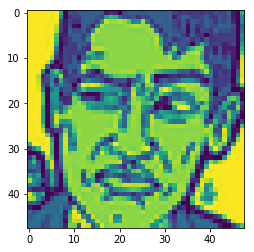

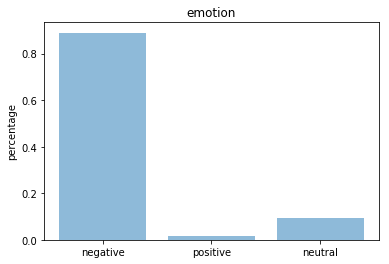

----------------------------------------
Actual Emotion: negative


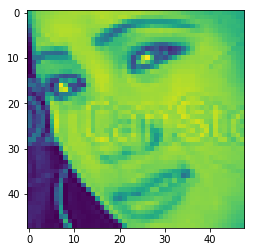

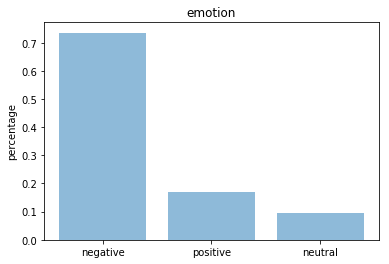

----------------------------------------
Actual Emotion: neutral


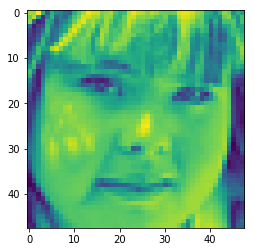

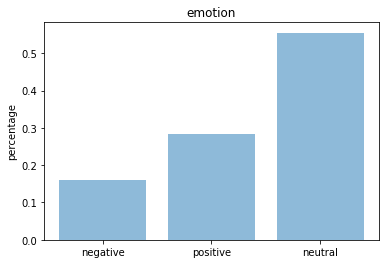

----------------------------------------
Actual Emotion: positive


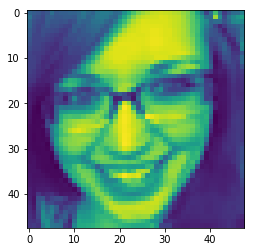

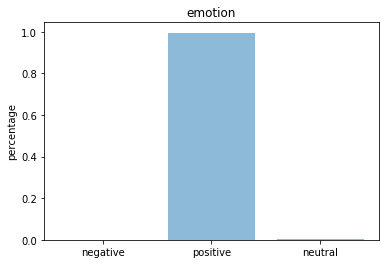

----------------------------------------
Actual Emotion: positive


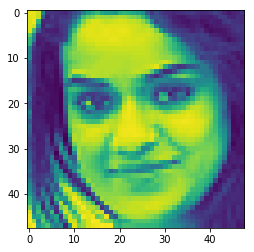

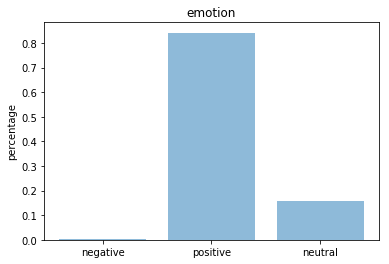

----------------------------------------


In [36]:
def display_predictions(_predictions, x, y, confidence, max_prediction=3):
    cur_prediction = 0
    for i, prediction_image in enumerate(_predictions):

        # only print out the first few items
        if (cur_prediction == max_prediction):
            break

        val = return_confidence(prediction_image)

        # returns results that model believes has a high probability of being correct
        if (confidence == False):
            val = not val
        
        if (val):
            testing_img = np.array(x[i], 'float32')
            testing_img = testing_img.reshape(width, height)

            print('Actual Emotion: {}'.format(dic[y[i].argmax(axis=-1)]))
            plt.imshow(testing_img)
            plt.show()
            emotion_breakdown(prediction_image)
            print('-' * 40)
            cur_prediction += 1

display_predictions(predictions, x_test, y_test, True, 5)

Actual Emotion: negative


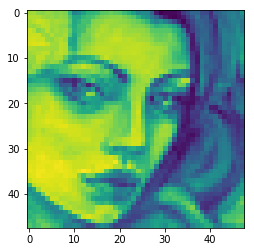

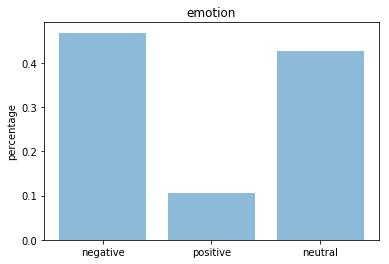

----------------------------------------
Actual Emotion: negative


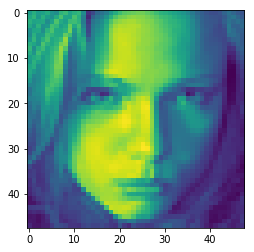

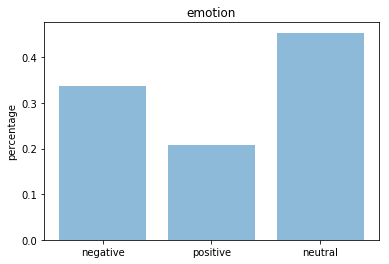

----------------------------------------
Actual Emotion: neutral


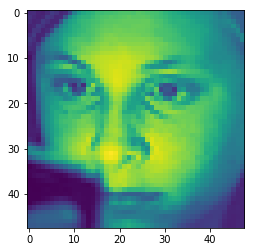

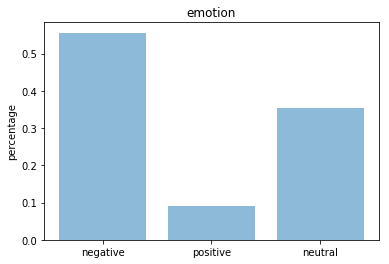

----------------------------------------


In [37]:
display_predictions(predictions, x_test, y_test, False)

One thing that seems prevalent is that the model seems to be having some difficulty at checking angry faces. It's possible that by grouping suprised and neutral emotions together caused some unwanted effects. The hypothesis is that by removing the suprised emotions from the neutral facial emotion, the model will be able to better identifying angry emotions.

In [38]:
# reinitialize training and test set
x_train, y_train, x_test, y_test = [], [], [], []

for i, instance in enumerate(faces):
    
    # skip first step; header
    if i == 0:
        continue
    
    emotion, pixel, usage = instance.split(',')
    
    img = np.array(pixel.split(" "))
    
    if emotion in ['0', '1', '3', '6']:
        
        # set 0 for negative emotion, 1 for positive, 2 for neutral
        if emotion == '0' or emotion == '1':
            emotion = '0'
        elif emotion == '3':
            emotion = '1'
        elif emotion == '6':
            emotion = '2'
    
        emotion = keras.utils.to_categorical(emotion, num_classes)
        
        if 'Training' in usage:
            x_train.append(img)
            y_train.append(emotion)
        else:
            x_test.append(img)
            y_test.append(emotion)
        
print("There are {} training data and {} test cases".format(len(y_train), len(y_test)))

There are 16611 training data and 4076 test cases


In [39]:
x_train, y_train, x_test, y_test, input_shape = convertListToArray(x_train, y_train, x_test, y_test, width, height)

In [40]:
# create CNN model
model = Sequential()

# first CNN layer
model.add(Conv2D(49, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

# second CNN layer
model.add(Conv2D(49, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))

# third CNN layer
model.add(Conv2D(98, (3,3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(784, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [41]:
model = load_or_save_model(model, model_path+model_name4, load_model)

Train on 16611 samples, validate on 4076 samples
Epoch 1/20
16611/16611 [==============================] - 7s 447us/step - loss: 1.0273 - acc: 0.4805 - val_loss: 1.0655 - val_acc: 0.5218
Epoch 2/20
16611/16611 [==============================] - 6s 373us/step - loss: 0.8157 - acc: 0.6286 - val_loss: 0.7384 - val_acc: 0.6803
Epoch 3/20
16611/16611 [==============================] - 6s 373us/step - loss: 0.7297 - acc: 0.6767 - val_loss: 0.6706 - val_acc: 0.7017
Epoch 4/20
16611/16611 [==============================] - 6s 373us/step - loss: 0.6862 - acc: 0.6969 - val_loss: 0.6045 - val_acc: 0.7419
Epoch 5/20
16611/16611 [==============================] - 6s 374us/step - loss: 0.6538 - acc: 0.7163 - val_loss: 0.5855 - val_acc: 0.7522
Epoch 6/20
16611/16611 [==============================] - 6s 373us/step - loss: 0.6249 - acc: 0.7310 - val_loss: 0.5929 - val_acc: 0.7453
Epoch 7/20
16611/16611 [==============================] - 6s 373us/step - loss: 0.6075 - acc: 0.7404 - val_loss: 0.5646 - v

In [42]:
predictions = model.predict(x_test)

show_confusion_matrix(predictions, emotion_values)

Actual      negative  positive  neutral
Prediction                             
negative         817       105      212
positive          95      1560      171
neutral          157       109      850


While the accuracy for both positive and neutral classifications were more accurate, the accuracy of correctly classifying negative emotions went down. It appears that by removing the suprised emotions from neutral, it actually made it harder for the model to correctly identify negative emotions. 

To see how well the model works for real world situations, it is now time to apply this model to a different dataset! Unfortunately, datasets containing faces are far and few. Instead, using google search, one can compile images from angry faces and happy faces. To do this, I used an extension called Google Images Downloader for Firefox and cleaned the data to remove any incorrect labeling.

In [43]:
import os
from PIL import Image
import re
from keras.preprocessing.image import img_to_array

data_dir = 'data'
resized_dir = '/resized'
original_dir = '/og'

In [44]:
# resizes images from directory into new subdirectory
def resize(folder, og_dir, new_dir, fileName, width, height):
    filePath = os.path.join(folder, fileName)
    im = Image.open(filePath)
    newIm = im.resize((int(width), int(height)))
    directory = re.sub(og_dir, new_dir, folder, count=1) 
    
    # create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # create new file only if it doesn't exist
    if not os.path.exists(directory + '/' + fileName):
        try:
            newIm.save(directory + '/' + fileName)
        except:
            newIm.close()

# finds images in directory
def bulkResize(imageFolder, original_dir, new_dir, width, height):
    imgExts = ["png", "bmp", "jpg"]
    
    for path, dirs, files in os.walk(imageFolder + original_dir):
        for fileName in files:
            ext = fileName[-3:].lower()
            if ext not in imgExts:
                continue

            resize(path, original_dir, new_dir, fileName, width, height)

bulkResize(data_dir, original_dir, resized_dir, width, height)

In [45]:
# convert image to array and add to df
def loadImgToArray(path, fileName):
    
    # don't count files if file is corrupt
    try:
        im = Image.open(path+'/'+fileName)
        im = im.convert('L') # convert RGB to 8bit black and white

        ar = img_to_array(im)

        # normalize values
        ar = ar/255.0

        reshape = ar.reshape(width*height*1)
        batch_array.append(reshape)
        remove = re.sub(data_dir+resized_dir, '', path)
        remove = re.sub(r'\\', '', remove)
        batch_label.append(remove)
    except:
        im.close()


# convert to arrays
def bulkConvert(imageFolder):
    imgExts = ["png", "bmp", "jpg"]
    for path, dirs, files in os.walk(imageFolder):
        for i,  fileName in enumerate(files):
            ext = fileName[-3:].lower()
            if ext not in imgExts:
                continue
            loadImgToArray(path, fileName)
    
    
batch_array = []
batch_label = []
bulkConvert(data_dir + resized_dir)

c:\users\brian\appdata\local\programs\python\python36\lib\site-packages\PIL\Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [46]:
# # Convert to float32
batch_array = np.asarray(batch_array, dtype=np.float32)
batch_label = np.asarray(batch_label, dtype=np.uint8)
batch_label = keras.utils.to_categorical(batch_label, num_classes)

# reshape values into image format
if K.image_data_format() == 'channels_first':
    batch_array = batch_array.reshape(batch_array.shape[0], 1, width, height)
    input_shape = (1, width, height)
else:
    batch_array = batch_array.reshape(batch_array.shape[0], width, height, 1)
    input_shape = (width, height, 1)

In [47]:
predictions = model.predict(batch_array)

In [48]:
# convert id values into string values
prediction_string = []
actual_string = []

for value in predictions.argmax(axis=-1):
    prediction_string.append(dic[value])

for value in batch_label.argmax(axis=-1):
    actual_string.append(dic[value])
    
    
# create categorical variables to input into crosstab
prediction = pd.Categorical(prediction_string, categories=emotion_values)
actual = pd.Categorical(actual_string, categories=emotion_values)

num_cross = pd.crosstab(prediction, actual, rownames=['Prediction'], colnames=['Actual'])
num_cross

Actual,negative,positive,neutral
Prediction,,,
negative,17,59,67
positive,6,130,79
neutral,6,51,87


In [49]:
print('Accuracy:',model.evaluate(batch_array, batch_label, verbose=0)[1])

Accuracy: 0.46613545876100243


Actual Emotion: negative


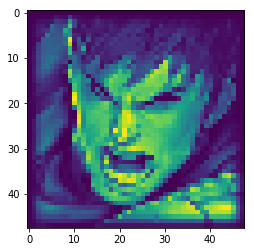

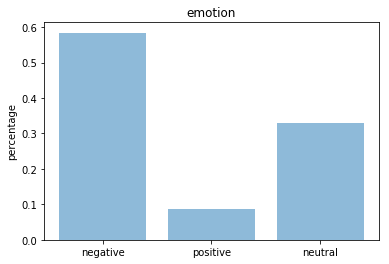

----------------------------------------
Actual Emotion: negative


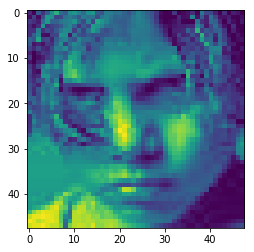

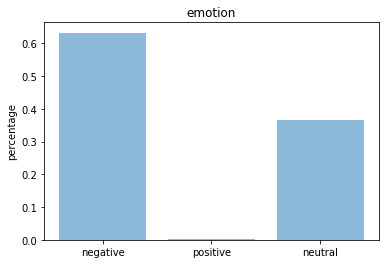

----------------------------------------
Actual Emotion: negative


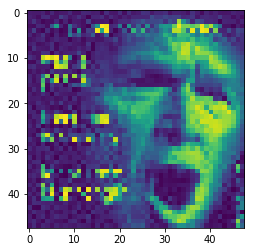

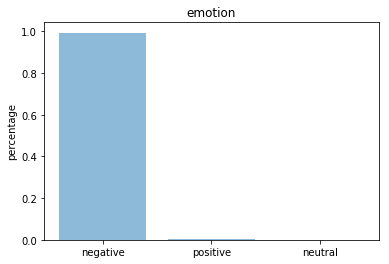

----------------------------------------


In [50]:
display_predictions(predictions, batch_array, batch_label, True)

Actual Emotion: negative


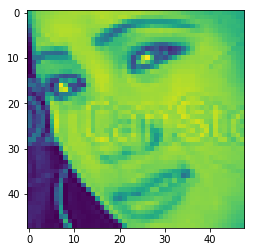

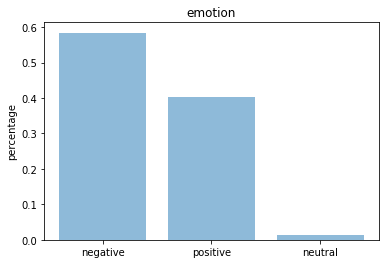

----------------------------------------
Actual Emotion: neutral


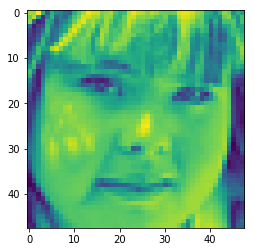

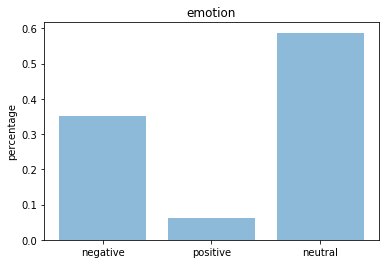

----------------------------------------
Actual Emotion: negative


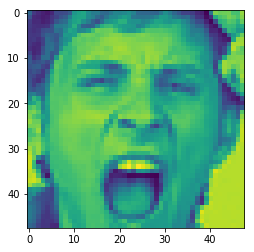

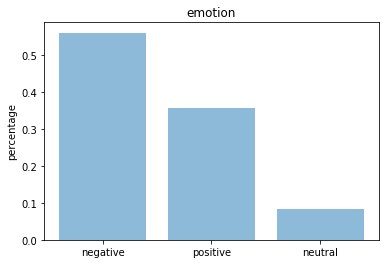

----------------------------------------


In [51]:
display_predictions(predictions, x_test, y_test, False)